# SPARQL Test for Wikidata and DBpedia with LC-QuAD 2.0

In [4]:
# import all the necessary libraries
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON

## Get distinct template_ids
Extracting all distinct template_ids from the LC-QuAD 2.0 dataset. This is done to see if all template_ids are covered by the number of test queries/questions. Here it should also be seen if certain queries templates are not working at all, meaning there is not problem with updated information or something, but that the template type is not supported, by either of the endpoints (https://skynet.coypu.org/wikidata/; localhost:8890/sparql). 

In [5]:
# Load the LC-QuAD 2.0 dataset
url = "https://raw.githubusercontent.com/AskNowQA/LC-QuAD2.0/refs/heads/master/dataset/train.json"
response = requests.get(url)
lc_quad_data = response.json()

# Extract distinct template_id values from the full dataset
all_template_ids = {entry.get("template_id") for entry in lc_quad_data if "template_id" in entry}

# Extract distinct template_id values from the first 200 questions
first_200_template_ids = {entry.get("template_id") for entry in lc_quad_data[:200] if "template_id" in entry}

# Check if all distinct template_ids from the full dataset are included in the first 200 questions
missing_template_ids = all_template_ids - first_200_template_ids

# Output the results
print("All template_ids from the full dataset:", all_template_ids)
print("Template_ids in the first 200 questions:", first_200_template_ids)

if not missing_template_ids:
    print("All distinct template_ids are included in the first 200 questions.")
else:
    print(f"The following template_ids are missing in the first 200 questions: {missing_template_ids}")

All template_ids from the full dataset: {'1', 1, 2, 3, '1.1', 5, 'statement_property_2', 'Rank2', 4, 'Count_2', '1.2', 'Rank1', 'Count_1', 'statement_property_1'}
Template_ids in the first 200 questions: {'1', 1, 2, 3, '1.1', 5, 'statement_property_2', 'Rank2', 4, 'Count_2', '1.2', 'Rank1', 'Count_1', 'statement_property_1'}
All distinct template_ids are included in the first 200 questions.


As a result all distinct template_ids are included in the first 200 queries of the LC-QuAD 2.0 dataset.

## Querying Wikidata endpoint
Using the LC-QuAD 2.0 dataset to query the wikidata endpoint (https://skynet.coypu.org/wikidata/). This is done to see if the queries are working and if the endpoint is able to return results. The results should provide answers, those that return "No answer", and queries that fail for some reason (are not properly able to be executed by the endpoint).

In order to achive this the SPARQL queries are executed, sending them to the endpoint and then checking the results and visualizing them in a chart. Further the results are saved in a excel file to manually check the "no answer" queries and see if they also fail when executing them in the skynet web interface as well as in the wiki data query service (https://query.wikidata.org/), also in order to find patterns, e.g. certain template_ids always failing. 

Number of queries with proper answers: 127
Number of queries with no answers: 73
Number of failed queries: 0


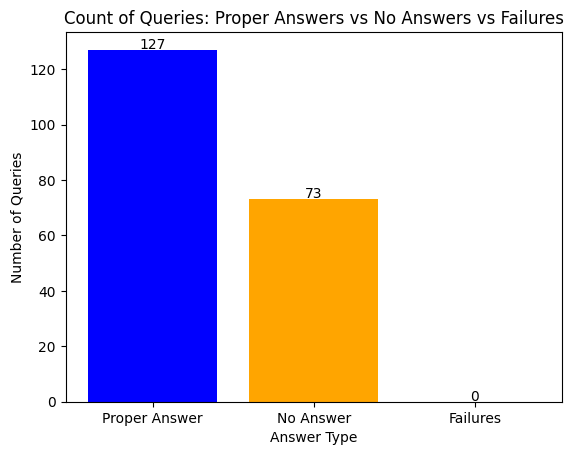

What periodical literature does Delta Air Lines use as a moutpiece?: Success, Answer: ['http://www.wikidata.org/entity/Q3486420']
Who is the child of Ranavalona I's husband?: Success, Answer: ['http://www.wikidata.org/entity/Q218622']
Is it true Jeff_Bridges occupation Lane Chandler and photographer ?: Success, Answer: ['False']
What is the pre-requisite of phase matter of Galinstan?: Success, Answer: ['No answer']
Which is the operating income for Qantas?: Success, Answer: ['1370000000']
which cola starts with the letter p: Success, Answer: ['http://www.wikidata.org/entity/Q100147873', 'Pepsi Perfect', 'http://www.wikidata.org/entity/Q47719', 'Pepsi', 'http://www.wikidata.org/entity/Q18387614', 'Pepsi True', 'http://www.wikidata.org/entity/Q3504021', 'Parsi Cola']
Is the right ascension of malin 1 less than 15.1398?: Success, Answer: ['False']
What is the complete list of records released by Jerry Lee Lewis?: Success, Answer: ['http://www.wikidata.org/entity/Q3029950']
What's Mary Lou

In [44]:
# Define the Skynet Coypu SPARQL endpoint
WIKIDATA_ENDPOINT = "https://skynet.coypu.org/wikidata/"

# Add prefixes once, to avoid repeating this step in each query, this is necessary for the skynet endpoint to work properly
PREFIXES = """
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
"""

def add_prefixes(sparql_query):
    """Add required prefixes to the SPARQL query."""
    return PREFIXES + sparql_query

# querying the SPARQL endpoint using the SPARQLWrapper library, seting the query and returning in JSON
def query_sparql(endpoint, query):
    """Send a SPARQL query to the specified endpoint and return the results."""
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60) # Set timeout to 60 seconds to avoid long waits
    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# handle different types of answers from the SPARQL query results. Furhter check if the answer is a Wikidata link or a literal
def extract_answer(results):
    """Extract the answer from the SPARQL query results, handling boolean answers."""
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    if not bindings:
        return ["No answer"]

    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            if value.startswith("http://www.wikidata.org/entity/"):
                answers.append(value)  # Keep the full Wikidata link
            else:
                answers.append(value)  # Append literals directly
    return answers if answers else ["No answer"]

# Initialize counters for proper/correct answers, no answers, and failures
proper_answer_count = 0
no_answer_count = 0
failure_count = 0

# Lists to hold query results
results = []

# Test the first 200 queries
for entry in lc_quad_data[:200]:
    sparql_query = entry.get('sparql_wikidata')
    question = entry.get('question')
    
    if sparql_query:
        # Add the necessary prefixes to the query
        query_with_prefixes = add_prefixes(sparql_query)
        result = query_sparql(WIKIDATA_ENDPOINT, query_with_prefixes)
        
        if result:
            answer = extract_answer(result)
            if "No answer" in answer:
                no_answer_count += 1
            else:
                proper_answer_count += 1
            results.append((question, 'Success', answer))
        else:
            failure_count += 1
            results.append((question, 'Failure', ['No answer']))

# Print the number of proper answers, no answers, and failures
print(f"Number of queries with proper answers: {proper_answer_count}")
print(f"Number of queries with no answers: {no_answer_count}")
print(f"Number of failed queries: {failure_count}")

# Prepare data for exporting to Excel
df = pd.DataFrame(results, columns=['Question', 'Result', 'Answer'])

# Save results to an Excel file for further inspection
df.to_excel("wikidata_results.xlsx", index=False)

# Visualize the results with a bar chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [proper_answer_count, no_answer_count, failure_count]

plt.bar(labels, sizes, color=['blue', 'orange', 'red'])
for i in range(len(labels)):
    plt.text(i, sizes[i] + 0.5, str(sizes[i]), ha='center')

plt.title('Count of Queries: Proper Answers vs No Answers vs Failures')
plt.ylabel('Number of Queries')
plt.xlabel('Answer Type')
plt.show()

# Optionally print the results for inspection
for question, result, answer in results:
    print(f"{question}: {result}, Answer: {answer}")

## Results wikidata query test with first 200 queries
Most of the queries can be exceuted and return correct results. However there are also so which don't return any answers. After checking those queries manually, for most of them the information is not available anymore, has been updated, changed or the connected entities are not available anymore. 

**template_id: "statement_property_2**: After manually checking the query results, it appears that all queries with the template_id "statement_property_1" & "statement_property_2" are not working. This is due to the fact that the endpoint is not able to execute the queries. The queries are not working in the skynet web interface, however most of them are working in wiki data query service (https://query.wikidata.org/). Those templates are also the ones which include qualifiers, which might be the reason for the failure.

For example: 
When position did Angela Merkel hold on November 10, 1994? (template_id: "statement_property_2"). When executing it in skynet with the following query: 
```
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>

SELECT ?obj WHERE { wd:Q567 p:P39 ?s . ?s ps:P39 ?obj . ?s pq:P580 ?x filter(contains(YEAR(?x),'1994'))}
```

It says: "No data available in table" 

When executing it in wiki data query service:
 
```
SELECT ?obj WHERE { wd:Q567 p:P39 ?s . ?s ps:P39 ?obj . ?s pq:P580 ?x filter(contains(YEAR(?x),'1994'))}
```
It returns the correct answer: 
wd:Q30544097 & wd:Q1939555

## Test for DBpedia endpoint

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 51: syntax error at '<' before 'Domestic'\n\nSPARQL query:\ndefine sql:big-data-const 0\n#output-format:application/sparql-results+json\n\nPREFIX as: <http://www.w3.org/ns/activitystreams#>\nPREFIX bif: <bif:>\nPREFIX dawgt: <http://www.w3.org/2001/sw/DataAccess/tests/test-dawg#>\nPREFIX dbpedia: <http://dbpedia.org/resource/>\nPREFIX dbpprop: <http://dbpedia.org/property/>\nPREFIX dc: <http://purl.org/dc/elements/1.1/>\nPREFIX fn: <http://www.w3.org/2005/xpath-functions/#>\nPREFIX foaf: <http://xmlns.com/foaf/0.1/>\nPREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>\nPREFIX go: <http://purl.org/obo/owl/GO#>\nPREFIX ldp: <http://www.w3.org/ns/ldp#>\nPREFIX math: <http://www.w3.org/2000/10/swap/math#>\nPREFIX mesh: <http://purl.org/commons/record/mesh/>\nPREFIX mf: <http://www.w3.org/2001/sw/DataAccess/t

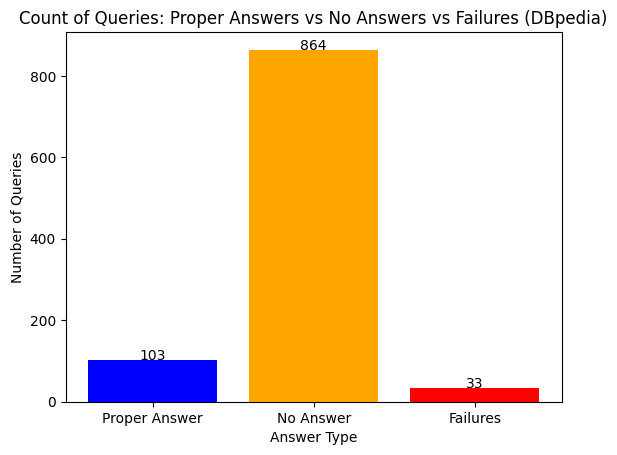

What periodical literature does Delta Air Lines use as a moutpiece?: Success, Answer: ['No answer']
Who is the child of Ranavalona I's husband?: Success, Answer: ['No answer']
Is it true Jeff_Bridges occupation Lane Chandler and photographer ?: Success, Answer: ['False']
What is the pre-requisite of phase matter of Galinstan?: Success, Answer: ['No answer']
Which is the operating income for Qantas?: Success, Answer: ['No answer']
which cola starts with the letter p: Success, Answer: ['No answer']
Is the right ascension of malin 1 less than 15.1398?: Success, Answer: ['False']
What is the complete list of records released by Jerry Lee Lewis?: Success, Answer: ['No answer']
What's Mary Lou Retton's International Olympic Committee athlete ID.: Success, Answer: ['No answer']
Who won the prize at the sequel of the 1885 Wimbledon Championships- Gentlemen's Singles?: Success, Answer: ['No answer']
Is it true that the carbon footprint of the iPhone X Max is 106?: Success, Answer: ['False']
Tel

In [6]:
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON

# Define the DBpedia SPARQL endpoint (assuming your Virtuoso instance is running locally)
DBPEDIA_ENDPOINT = "http://localhost:8897/sparql"

# Add prefixes for DBpedia queries
DBPEDIA_PREFIXES = """
PREFIX as: <http://www.w3.org/ns/activitystreams#>
PREFIX bif: <bif:>
PREFIX dawgt: <http://www.w3.org/2001/sw/DataAccess/tests/test-dawg#>
PREFIX dbpedia: <http://dbpedia.org/resource/>
PREFIX dbpprop: <http://dbpedia.org/property/>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX fn: <http://www.w3.org/2005/xpath-functions/#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX go: <http://purl.org/obo/owl/GO#>
PREFIX ldp: <http://www.w3.org/ns/ldp#>
PREFIX math: <http://www.w3.org/2000/10/swap/math#>
PREFIX mesh: <http://purl.org/commons/record/mesh/>
PREFIX mf: <http://www.w3.org/2001/sw/DataAccess/tests/test-manifest#>
PREFIX nci: <http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus.owl#>
PREFIX obo: <http://www.geneontology.org/formats/oboInOwl#>
PREFIX ogc: <http://www.opengis.net/>
PREFIX ogcgml: <http://www.opengis.net/ont/gml#>
PREFIX ogcgs: <http://www.opengis.net/ont/geosparql#>
PREFIX ogcgsf: <http://www.opengis.net/def/function/geosparql/>
PREFIX ogcgsr: <http://www.opengis.net/def/rule/geosparql/>
PREFIX ogcsf: <http://www.opengis.net/ont/sf#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX product: <http://www.buy.com/rss/module/productV2/>
PREFIX protseq: <http://purl.org/science/protein/bysequence/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfa: <http://www.w3.org/ns/rdfa#>
PREFIX rdfdf: <http://www.openlinksw.com/virtrdf-data-formats#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sc: <http://purl.org/science/owl/sciencecommons/>
PREFIX scovo: <http://purl.org/NET/scovo#>
PREFIX sd: <http://www.w3.org/ns/sparql-service-description#>
PREFIX sioc: <http://rdfs.org/sioc/ns#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX sql: <sql:>
PREFIX vcard: <http://www.w3.org/2001/vcard-rdf/3.0#>
PREFIX vcard2006: <http://www.w3.org/2006/vcard/ns#>
PREFIX virtcxml: <http://www.openlinksw.com/schemas/virtcxml#>
PREFIX virtrdf: <http://www.openlinksw.com/schemas/virtrdf#>
PREFIX void: <http://rdfs.org/ns/void#>
PREFIX xf: <http://www.w3.org/2004/07/xpath-functions>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX xsl10: <http://www.w3.org/XSL/Transform/1.0>
PREFIX xsl1999: <http://www.w3.org/1999/XSL/Transform>
PREFIX xslwd: <http://www.w3.org/TR/WD-xsl>
PREFIX yago: <http://dbpedia.org/class/yago/>
"""

def add_dbpedia_prefixes(sparql_query):
    """Add required prefixes to the SPARQL query for DBpedia."""
    return DBPEDIA_PREFIXES + sparql_query

# Query the SPARQL endpoint using the SPARQLWrapper library
def query_sparql(endpoint, query):
    """Send a SPARQL query to the specified endpoint and return the results."""
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to 60 seconds to avoid long waits
    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# Extract answers from DBpedia SPARQL results
def extract_answer(results):
    """Extract the answer from the SPARQL query results, handling boolean answers."""
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    if not bindings:
        return ["No answer"]

    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            if value.startswith("http://dbpedia.org/resource/"):
                answers.append(value)  # Keep the full DBpedia link
            else:
                answers.append(value)  # Append literals directly
    return answers if answers else ["No answer"]

# Initialize counters for proper/correct answers, no answers, and failures
proper_answer_count = 0
no_answer_count = 0
failure_count = 0

# Lists to hold query results
results = []

# Test the first 1000 queries for DBpedia
for entry in lc_quad_data[:1000]:
    sparql_query = entry.get('sparql_dbpedia18')  # Use DBpedia-specific queries
    question = entry.get('question')
    
    if sparql_query:
        # Add the necessary prefixes to the query
        query_with_prefixes = add_dbpedia_prefixes(sparql_query)
        result = query_sparql(DBPEDIA_ENDPOINT, query_with_prefixes)
        
        if result:
            answer = extract_answer(result)
            if "No answer" in answer:
                no_answer_count += 1
            else:
                proper_answer_count += 1
            results.append((question, 'Success', answer))
        else:
            failure_count += 1
            results.append((question, 'Failure', ['No answer']))

# Print the number of proper answers, no answers, and failures
print(f"Number of queries with proper answers: {proper_answer_count}")
print(f"Number of queries with no answers: {no_answer_count}")
print(f"Number of failed queries: {failure_count}")

# Prepare data for exporting to Excel
df = pd.DataFrame(results, columns=['Question', 'Result', 'Answer'])

# Save results to an Excel file for further inspection
df.to_excel("dbpedia_results.xlsx", index=False)

# Visualize the results with a bar chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [proper_answer_count, no_answer_count, failure_count]

plt.bar(labels, sizes, color=['blue', 'orange', 'red'])
for i in range(len(labels)):
    plt.text(i, sizes[i] + 0.5, str(sizes[i]), ha='center')

plt.title('Count of Queries: Proper Answers vs No Answers vs Failures (DBpedia)')
plt.ylabel('Number of Queries')
plt.xlabel('Answer Type')
plt.show()

# Optionally print the results for inspection
for question, result, answer in results:
    print(f"{question}: {result}, Answer: {answer}")


In [6]:
def adjust_dbpedia_query(sparql_query):
    """
    Adjusts a query written for 'sparql_dbpedia18' by replacing Wikidata URIs with DBpedia URIs.
    """
    sparql_query = sparql_query.replace("http://wikidata.dbpedia.org/resource/", "http://dbpedia.org/resource/")
    sparql_query = sparql_query.replace("http://www.wikidata.org/entity/", "http://dbpedia.org/ontology/")
    sparql_query = sparql_query.replace("rdf:type", "dbo:type")
    # Add more property-specific replacements as needed
    return sparql_query


In [7]:
DBPEDIA_PREFIXES = """
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
"""

Query failed: timed out
Query failed: timed out
Query failed: timed out
Number of queries with proper answers: 51
Number of queries with no answers: 240
Number of failed queries: 9


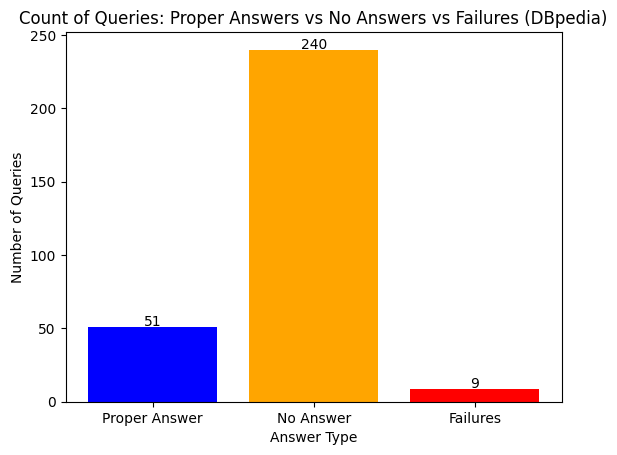

What periodical literature does Delta Air Lines use as a moutpiece?: Success, Answer: ['No answer']
Who is the child of Ranavalona I's husband?: Success, Answer: ['No answer']
Is it true Jeff_Bridges occupation Lane Chandler and photographer ?: Success, Answer: ['False']
What is the pre-requisite of phase matter of Galinstan?: Success, Answer: ['No answer']
Which is the operating income for Qantas?: Success, Answer: ['No answer']
which cola starts with the letter p: Success, Answer: ['No answer']
Is the right ascension of malin 1 less than 15.1398?: Success, Answer: ['False']
What is the complete list of records released by Jerry Lee Lewis?: Success, Answer: ['No answer']
What's Mary Lou Retton's International Olympic Committee athlete ID.: Success, Answer: ['No answer']
Who won the prize at the sequel of the 1885 Wimbledon Championships- Gentlemen's Singles?: Success, Answer: ['No answer']
Is it true that the carbon footprint of the iPhone X Max is 106?: Success, Answer: ['False']
Tel

In [9]:
for entry in lc_quad_data[:100]:
    sparql_query = entry.get('sparql_dbpedia18')  # Use DBpedia-specific queries
    question = entry.get('question')

    if sparql_query:
        # Adjust the query to resolve DBpedia resources and properties
        query_with_prefixes = add_dbpedia_prefixes(adjust_dbpedia_query(sparql_query))
        result = query_sparql(DBPEDIA_ENDPOINT, query_with_prefixes)
        
        if result:
            answer = extract_answer(result)
            if "No answer" in answer:
                no_answer_count += 1
            else:
                proper_answer_count += 1
            results.append((question, 'Success', answer))
        else:
            failure_count += 1
            results.append((question, 'Failure', ['No answer']))
            
# Print the number of proper answers, no answers, and failures
print(f"Number of queries with proper answers: {proper_answer_count}")
print(f"Number of queries with no answers: {no_answer_count}")
print(f"Number of failed queries: {failure_count}")

# Prepare data for exporting to Excel
df = pd.DataFrame(results, columns=['Question', 'Result', 'Answer'])

# Save results to an Excel file for further inspection
df.to_excel("dbpedia_results.xlsx", index=False)

# Visualize the results with a bar chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [proper_answer_count, no_answer_count, failure_count]

plt.bar(labels, sizes, color=['blue', 'orange', 'red'])
for i in range(len(labels)):
    plt.text(i, sizes[i] + 0.5, str(sizes[i]), ha='center')

plt.title('Count of Queries: Proper Answers vs No Answers vs Failures (DBpedia)')
plt.ylabel('Number of Queries')
plt.xlabel('Answer Type')
plt.show()

# Optionally print the results for inspection
for question, result, answer in results:
    print(f"{question}: {result}, Answer: {answer}")



## Test for Wikidata with new data source (QALD-9)

Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"SPARQL-QUERY: queryStr=PREFIX wd: <http://www.wikidata.org/entity/> PREFIX wdt: <http://www.wikidata.org/prop/direct/> PREFIX pq: <http://www.wikidata.org/prop/qualifier/> PREFIX ps: <http://www.wikidata.org/prop/statement/> PREFIX p: <http://www.wikidata.org/prop/>  SELECT ?res WHERE { ?res p:P39 _:a . _:a ps:P39 wd:Q22575092 . :a pq:P580 ?start . } ORDER BY DESC(?start) LIMIT 1\njava.util.concurrent.ExecutionException: org.openrdf.query.MalformedQueryException: com.bigdata.rdf.sail.sparql.ast.VisitorException: QName ':a' uses an undefined prefix\n\tat java.util.concurrent.FutureTask.report(FutureTask.java:122)\n\tat java.util.concurrent.FutureTask.get(FutureTask.java:206)\n\tat com.bigdata.rdf.sail.webapp.BigdataServlet.submitA

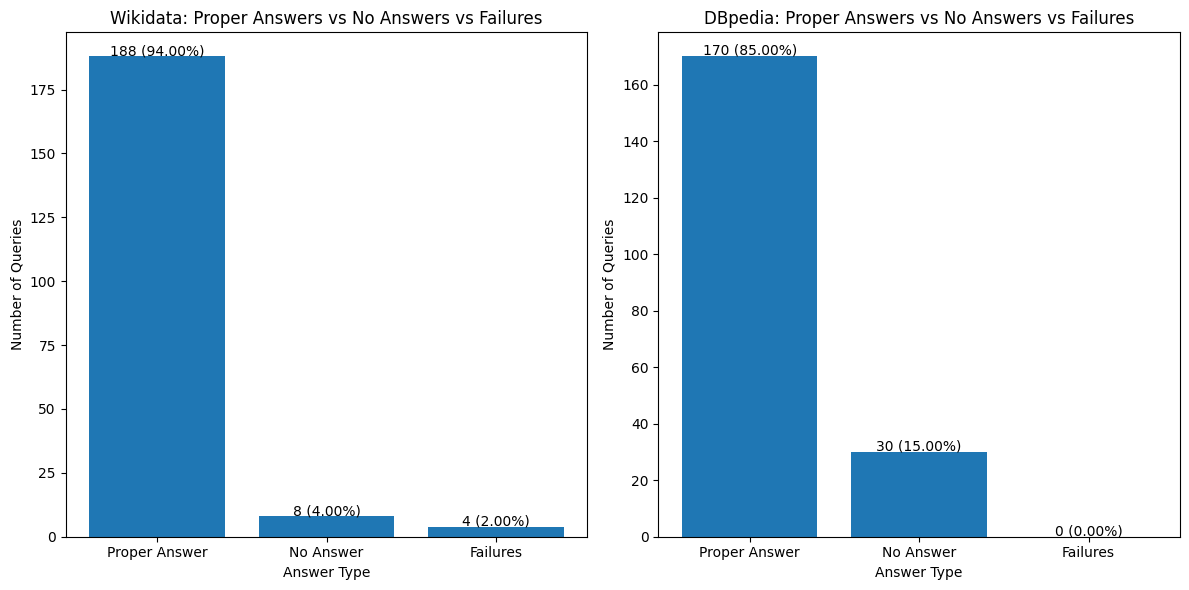

In [5]:
# Import necessary libraries
import requests
import json
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt

# Load new QALD-9 datasets for Wikidata and DBpedia
wikidata_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_wikidata.json"
dbpedia_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_dbpedia.json"

wikidata_data = requests.get(wikidata_url).json()
dbpedia_data = requests.get(dbpedia_url).json()

# Define SPARQL endpoints for Wikidata and DBpedia
WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"
DBPEDIA_ENDPOINT = "https://dbpedia.org/sparql"

# Function to query SPARQL endpoint with User-Agent
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to avoid long waits
    sparql.addCustomHttpHeader("User-Agent", "QALDQueryTool/1.0 (contact@example.com)")

    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# Extract the answer from SPARQL query results
def extract_answer(results):
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Keep the value as it is
    return answers if answers else ["No answer"]

# Helper function to extract English questions and IDs from QALD-9 format
def extract_questions(dataset, language="en"):
    questions = []
    for entry in dataset["questions"]:
        question_data = next((q for q in entry["question"] if q["language"] == language), None)
        if question_data:
            questions.append({
                "id": entry["id"],
                "question": question_data["string"],
                "sparql": entry["query"]["sparql"]
            })
    return questions

# Prepare questions from Wikidata and DBpedia datasets (restrict to first 200)
wikidata_questions = extract_questions(wikidata_data, language="en")[:200]
dbpedia_questions = extract_questions(dbpedia_data, language="en")[:200]

# Initialize counters and results list
wikidata_counts = {"proper_answer": 0, "no_answer": 0, "failure": 0}
dbpedia_counts = {"proper_answer": 0, "no_answer": 0, "failure": 0}
wikidata_results = []
dbpedia_results = []

# Function to execute queries and process answers
def process_queries(questions, endpoint, results_list, counts_dict):
    for entry in questions:
        sparql_query = entry.get('sparql')
        question = entry.get('question')
        
        if sparql_query:
            result = query_sparql(endpoint, sparql_query)
            if result:
                answer = extract_answer(result)
                if "No answer" in answer:
                    counts_dict["no_answer"] += 1
                else:
                    counts_dict["proper_answer"] += 1
                results_list.append((question, entry["id"], 'Success', answer))
            else:
                counts_dict["failure"] += 1
                results_list.append((question, entry["id"], 'Failure', ['No answer']))

# Process only first 10 queries for both datasets
process_queries(wikidata_questions, WIKIDATA_ENDPOINT, wikidata_results, wikidata_counts)
process_queries(dbpedia_questions, DBPEDIA_ENDPOINT, dbpedia_results, dbpedia_counts)

# Calculate percentages for each dataset
def calculate_percentages(counts):
    total = counts["proper_answer"] + counts["no_answer"] + counts["failure"]
    proper_answer_pct = (counts["proper_answer"] / total) * 100 if total > 0 else 0
    no_answer_pct = (counts["no_answer"] / total) * 100 if total > 0 else 0
    failure_pct = (counts["failure"] / total) * 100 if total > 0 else 0
    return proper_answer_pct, no_answer_pct, failure_pct

wikidata_proper_pct, wikidata_no_pct, wikidata_failure_pct = calculate_percentages(wikidata_counts)
dbpedia_proper_pct, dbpedia_no_pct, dbpedia_failure_pct = calculate_percentages(dbpedia_counts)

# Print counts and percentages
print("Wikidata Results:")
print(f"Proper answers: {wikidata_counts['proper_answer']} ({wikidata_proper_pct:.2f}%)")
print(f"No answers: {wikidata_counts['no_answer']} ({wikidata_no_pct:.2f}%)")
print(f"Failures: {wikidata_counts['failure']} ({wikidata_failure_pct:.2f}%)\n")

print("DBpedia Results:")
print(f"Proper answers: {dbpedia_counts['proper_answer']} ({dbpedia_proper_pct:.2f}%)")
print(f"No answers: {dbpedia_counts['no_answer']} ({dbpedia_no_pct:.2f}%)")
print(f"Failures: {dbpedia_counts['failure']} ({dbpedia_failure_pct:.2f}%)\n")

# Combine results and save to Excel
wikidata_df = pd.DataFrame(wikidata_results, columns=['Question', 'ID', 'Result', 'Answer'])
dbpedia_df = pd.DataFrame(dbpedia_results, columns=['Question', 'ID', 'Result', 'Answer'])

with pd.ExcelWriter("qald9_test_results_split.xlsx") as writer:
    wikidata_df.to_excel(writer, sheet_name="Wikidata Results", index=False)
    dbpedia_df.to_excel(writer, sheet_name="DBpedia Results", index=False)

# Visualize the results with separate bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Wikidata chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [wikidata_counts["proper_answer"], wikidata_counts["no_answer"], wikidata_counts["failure"]]

ax1.bar(labels, sizes)
for i in range(len(labels)):
    ax1.text(i, sizes[i] + 0.5, f"{sizes[i]} ({[wikidata_proper_pct, wikidata_no_pct, wikidata_failure_pct][i]:.2f}%)", ha='center')

ax1.set_title('Wikidata: Proper Answers vs No Answers vs Failures')
ax1.set_ylabel('Number of Queries')
ax1.set_xlabel('Answer Type')

# DBpedia chart
sizes = [dbpedia_counts["proper_answer"], dbpedia_counts["no_answer"], dbpedia_counts["failure"]]

ax2.bar(labels, sizes)
for i in range(len(labels)):
    ax2.text(i, sizes[i] + 0.5, f"{sizes[i]} ({[dbpedia_proper_pct, dbpedia_no_pct, dbpedia_failure_pct][i]:.2f}%)", ha='center')

ax2.set_title('DBpedia: Proper Answers vs No Answers vs Failures')
ax2.set_ylabel('Number of Queries')
ax2.set_xlabel('Answer Type')

plt.tight_layout()
plt.show()

## Check Skynet (Local Wikidata) endpoint


Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'Parse error: Variable used when already in-scope: ?uri in ((AGG ?.0 COUNT(DISTINCT ?uri)) AS ?uri)\n'
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation ti

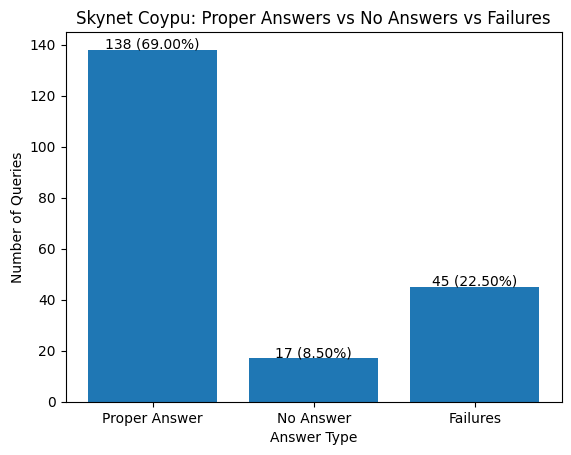

In [7]:
# Load new QALD-9 datasets for Wikidata
wikidata_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_wikidata.json"
wikidata_data = requests.get(wikidata_url).json()

# Define SPARQL endpoints
SKYNET_COYPU_WIKIDATA_ENDPOINT = "https://skynet.coypu.org/wikidata/"

# Define prefixes for the Skynet Coypu endpoint
PREFIXES = """
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
"""

# Function to add prefixes to the SPARQL query
def add_prefixes(sparql_query):
    return PREFIXES + sparql_query

# Function to query SPARQL endpoint with User-Agent
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to avoid long waits
    sparql.addCustomHttpHeader("User-Agent", "QALDQueryTool/1.0 (contact@example.com)")

    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# Extract the answer from SPARQL query results
def extract_answer(results):
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Keep the value as it is
    return answers if answers else ["No answer"]

# Helper function to extract English questions and IDs from QALD-9 format
def extract_questions(dataset, language="en"):
    questions = []
    for entry in dataset["questions"]:
        question_data = next((q for q in entry["question"] if q["language"] == language), None)
        if question_data:
            questions.append({
                "id": entry["id"],
                "question": question_data["string"],
                "sparql": entry["query"]["sparql"]
            })
    return questions

# Prepare questions from Wikidata dataset (restrict to first 10)
wikidata_questions = extract_questions(wikidata_data, language="en")[:200]

# Initialize counters and results list
skynet_counts = {"proper_answer": 0, "no_answer": 0, "failure": 0}
skynet_results = []

# Function to execute queries with prefixes for Skynet Coypu endpoint
def process_skynet_queries(questions, endpoint, results_list, counts_dict):
    for entry in questions:
        sparql_query = entry.get('sparql')
        question = entry.get('question')
        
        if sparql_query:
            # Add prefixes to the query for Skynet Coypu
            query_with_prefixes = add_prefixes(sparql_query)
            result = query_sparql(endpoint, query_with_prefixes)
            if result:
                answer = extract_answer(result)
                if "No answer" in answer:
                    counts_dict["no_answer"] += 1
                else:
                    counts_dict["proper_answer"] += 1
                results_list.append((question, entry["id"], 'Success', answer))
            else:
                counts_dict["failure"] += 1
                results_list.append((question, entry["id"], 'Failure', ['No answer']))

# Process only first 10 queries for Skynet Coypu
process_skynet_queries(wikidata_questions, SKYNET_COYPU_WIKIDATA_ENDPOINT, skynet_results, skynet_counts)

# Calculate percentages for Skynet Coypu
def calculate_percentages(counts):
    total = counts["proper_answer"] + counts["no_answer"] + counts["failure"]
    proper_answer_pct = (counts["proper_answer"] / total) * 100 if total > 0 else 0
    no_answer_pct = (counts["no_answer"] / total) * 100 if total > 0 else 0
    failure_pct = (counts["failure"] / total) * 100 if total > 0 else 0
    return proper_answer_pct, no_answer_pct, failure_pct

skynet_proper_pct, skynet_no_pct, skynet_failure_pct = calculate_percentages(skynet_counts)

# Print counts and percentages for Skynet Coypu results
print("Skynet Coypu Results:")
print(f"Proper answers: {skynet_counts['proper_answer']} ({skynet_proper_pct:.2f}%)")
print(f"No answers: {skynet_counts['no_answer']} ({skynet_no_pct:.2f}%)")
print(f"Failures: {skynet_counts['failure']} ({skynet_failure_pct:.2f}%)\n")

# Save Skynet results to an Excel file
skynet_df = pd.DataFrame(skynet_results, columns=['Question', 'ID', 'Result', 'Answer'])

with pd.ExcelWriter("skynet_test_results.xlsx") as writer:
    skynet_df.to_excel(writer, sheet_name="Skynet Coypu Results", index=False)

# Visualize the results with a bar chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [skynet_counts["proper_answer"], skynet_counts["no_answer"], skynet_counts["failure"]]

plt.bar(labels, sizes)
for i in range(len(labels)):
    plt.text(i, sizes[i] + 0.5, f"{sizes[i]} ({[skynet_proper_pct, skynet_no_pct, skynet_failure_pct][i]:.2f}%)", ha='center')

plt.title('Skynet Coypu: Proper Answers vs No Answers vs Failures')
plt.ylabel('Number of Queries')
plt.xlabel('Answer Type')
plt.show()


Trying without the prefixes to boost performance

In [ ]:
# Load new QALD-9 dataset for Wikidata
wikidata_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_wikidata.json"
wikidata_data = requests.get(wikidata_url).json()

# Define Skynet Coypu SPARQL endpoint
SKYNET_COYPU_WIKIDATA_ENDPOINT = "https://skynet.coypu.org/wikidata/"

# Function to query SPARQL endpoint with User-Agent
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to avoid long waits
    sparql.addCustomHttpHeader("User-Agent", "QALDQueryTool/1.0 (contact@example.com)")

    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# Extract the answer from SPARQL query results
def extract_answer(results):
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Keep the value as it is
    return answers if answers else ["No answer"]

# Helper function to extract English questions and IDs from QALD-9 format
def extract_questions(dataset, language="en"):
    questions = []
    for entry in dataset["questions"]:
        question_data = next((q for q in entry["question"] if q["language"] == language), None)
        if question_data:
            questions.append({
                "id": entry["id"],
                "question": question_data["string"],
                "sparql": entry["query"]["sparql"]
            })
    return questions

# Prepare questions from Wikidata dataset (restrict to first 10)
wikidata_questions = extract_questions(wikidata_data, language="en")[:10]

# Initialize counters and results list
skynet_counts = {"proper_answer": 0, "no_answer": 0, "failure": 0}
skynet_results = []

# Function to execute queries without prefixes for Skynet Coypu endpoint
def process_skynet_queries_no_prefixes(questions, endpoint, results_list, counts_dict):
    for entry in questions:
        sparql_query = entry.get('sparql')
        question = entry.get('question')
        
        if sparql_query:
            # Directly query without adding prefixes
            result = query_sparql(endpoint, sparql_query)
            if result:
                answer = extract_answer(result)
                if "No answer" in answer:
                    counts_dict["no_answer"] += 1
                else:
                    counts_dict["proper_answer"] += 1
                results_list.append((question, entry["id"], 'Success', answer))
            else:
                counts_dict["failure"] += 1
                results_list.append((question, entry["id"], 'Failure', ['No answer']))

# Process only first 10 queries for Skynet Coypu without prefixes
process_skynet_queries_no_prefixes(wikidata_questions, SKYNET_COYPU_WIKIDATA_ENDPOINT, skynet_results, skynet_counts)

# Calculate percentages for Skynet Coypu results
def calculate_percentages(counts):
    total = counts["proper_answer"] + counts["no_answer"] + counts["failure"]
    proper_answer_pct = (counts["proper_answer"] / total) * 100 if total > 0 else 0
    no_answer_pct = (counts["no_answer"] / total) * 100 if total > 0 else 0
    failure_pct = (counts["failure"] / total) * 100 if total > 0 else 0
    return proper_answer_pct, no_answer_pct, failure_pct

skynet_proper_pct, skynet_no_pct, skynet_failure_pct = calculate_percentages(skynet_counts)

# Print counts and percentages for Skynet Coypu results
print("Skynet Coypu Results (No Prefixes):")
print(f"Proper answers: {skynet_counts['proper_answer']} ({skynet_proper_pct:.2f}%)")
print(f"No answers: {skynet_counts['no_answer']} ({skynet_no_pct:.2f}%)")
print(f"Failures: {skynet_counts['failure']} ({skynet_failure_pct:.2f}%)\n")

# Save Skynet results to an Excel file
skynet_df = pd.DataFrame(skynet_results, columns=['Question', 'ID', 'Result', 'Answer'])

with pd.ExcelWriter("skynet_test_results_no_prefixes.xlsx") as writer:
    skynet_df.to_excel(writer, sheet_name="Skynet Coypu Results (No Prefixes)", index=False)

# Visualize the results with a bar chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [skynet_counts["proper_answer"], skynet_counts["no_answer"], skynet_counts["failure"]]

plt.bar(labels, sizes)
for i in range(len(labels)):
    plt.text(i, sizes[i] + 0.5, f"{sizes[i]} ({[skynet_proper_pct, skynet_no_pct, skynet_failure_pct][i]:.2f}%)", ha='center')

plt.title('Skynet Coypu: Proper Answers vs No Answers vs Failures (No Prefixes)')
plt.ylabel('Number of Queries')
plt.xlabel('Answer Type')
plt.show()

Check qulifiers only for wikidata Query service

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"SPARQL-QUERY: queryStr=PREFIX wd: <http://www.wikidata.org/entity/> PREFIX wdt: <http://www.wikidata.org/prop/direct/> PREFIX pq: <http://www.wikidata.org/prop/qualifier/> PREFIX ps: <http://www.wikidata.org/prop/statement/> PREFIX p: <http://www.wikidata.org/prop/>  SELECT ?res WHERE { ?res p:P39 _:a . _:a ps:P39 wd:Q22575092 . :a pq:P580 ?start . } ORDER BY DESC(?start) LIMIT 1\njava.util.concurrent.ExecutionException: org.openrdf.query.MalformedQueryException: com.bigdata.rdf.sail.sparql.ast.VisitorException: QName ':a' uses an undefined prefix\n\tat java.util.concurrent.FutureTask.report(FutureTask.java:122)\n\tat java.util.concurrent.FutureTask.get(FutureTask.java:206)\n\tat com.bigdata.rdf.sail.webapp.BigdataServlet.submitApiTask(BigdataServlet.java:292)\n\tat com.bigdata.rdf.sail.webapp.QueryServlet.doSparqlQuery(QueryServlet.java:678)\n\tat com.big

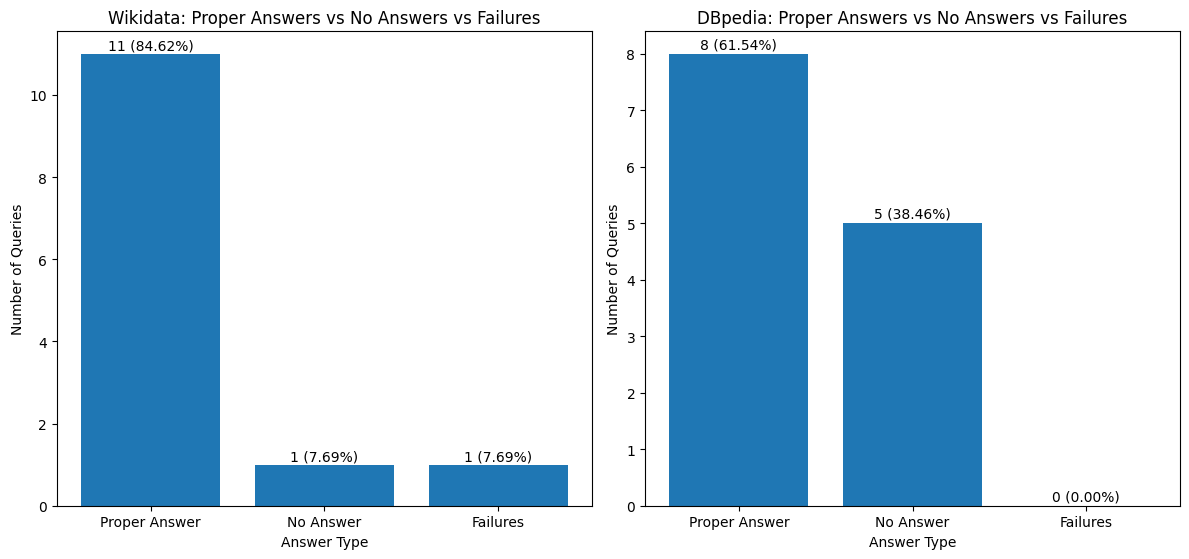

In [9]:
# Load QALD-9 datasets for Wikidata and DBpedia
wikidata_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_wikidata.json"
dbpedia_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_dbpedia.json"

wikidata_data = requests.get(wikidata_url).json()
dbpedia_data = requests.get(dbpedia_url).json()

# Define SPARQL endpoints for Wikidata and DBpedia
WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"
DBPEDIA_ENDPOINT = "https://dbpedia.org/sparql"

# Function to query SPARQL endpoint with User-Agent
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to avoid long waits
    sparql.addCustomHttpHeader("User-Agent", "QALDQueryTool/1.0 (contact@example.com)")

    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# Extract the answer from SPARQL query results
def extract_answer(results):
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Keep the value as it is
    return answers if answers else ["No answer"]

# Extract Wikidata questions with qualifiers and corresponding DBpedia questions
def extract_qualified_questions(wikidata_data, dbpedia_data):
    qualified_wikidata = []
    qualified_dbpedia = []

    # Filter Wikidata questions containing "pq:" in the SPARQL query
    wikidata_qualifiers = [
        q for q in wikidata_data["questions"]
        if "pq:" in q["query"]["sparql"]
    ]

    # Match each Wikidata question with its corresponding DBpedia question using "id"
    for entry in wikidata_qualifiers:
        question_id = entry["id"]
        wikidata_question_data = {
            "id": question_id,
            "question": next((q["string"] for q in entry["question"] if q["language"] == "en"), None),
            "sparql": entry["query"]["sparql"]
        }
        qualified_wikidata.append(wikidata_question_data)

        # Find the matching DBpedia question
        dbpedia_entry = next((q for q in dbpedia_data["questions"] if q["id"] == question_id), None)
        if dbpedia_entry:
            dbpedia_question_data = {
                "id": question_id,
                "question": next((q["string"] for q in dbpedia_entry["question"] if q["language"] == "en"), None),
                "sparql": dbpedia_entry["query"]["sparql"]
            }
            qualified_dbpedia.append(dbpedia_question_data)

    return qualified_wikidata, qualified_dbpedia

# Get qualified questions for both Wikidata and DBpedia
qualified_wikidata, qualified_dbpedia = extract_qualified_questions(wikidata_data, dbpedia_data)

# Initialize counters and results lists
wikidata_counts = {"proper_answer": 0, "no_answer": 0, "failure": 0}
dbpedia_counts = {"proper_answer": 0, "no_answer": 0, "failure": 0}
wikidata_results = []
dbpedia_results = []

# Function to execute queries and process answers
def process_queries(questions, endpoint, results_list, counts_dict):
    for entry in questions:
        sparql_query = entry.get('sparql')
        question = entry.get('question')
        
        if sparql_query:
            result = query_sparql(endpoint, sparql_query)
            if result:
                answer = extract_answer(result)
                if "No answer" in answer:
                    counts_dict["no_answer"] += 1
                else:
                    counts_dict["proper_answer"] += 1
                results_list.append((question, entry["id"], 'Success', answer))
            else:
                counts_dict["failure"] += 1
                results_list.append((question, entry["id"], 'Failure', ['No answer']))

# Process qualified queries for both Wikidata and DBpedia
process_queries(qualified_wikidata, WIKIDATA_ENDPOINT, wikidata_results, wikidata_counts)
process_queries(qualified_dbpedia, DBPEDIA_ENDPOINT, dbpedia_results, dbpedia_counts)

# Calculate percentages for each dataset
def calculate_percentages(counts):
    total = counts["proper_answer"] + counts["no_answer"] + counts["failure"]
    proper_answer_pct = (counts["proper_answer"] / total) * 100 if total > 0 else 0
    no_answer_pct = (counts["no_answer"] / total) * 100 if total > 0 else 0
    failure_pct = (counts["failure"] / total) * 100 if total > 0 else 0
    return proper_answer_pct, no_answer_pct, failure_pct

wikidata_proper_pct, wikidata_no_pct, wikidata_failure_pct = calculate_percentages(wikidata_counts)
dbpedia_proper_pct, dbpedia_no_pct, dbpedia_failure_pct = calculate_percentages(dbpedia_counts)

# Print counts and percentages
print("Wikidata Results:")
print(f"Proper answers: {wikidata_counts['proper_answer']} ({wikidata_proper_pct:.2f}%)")
print(f"No answers: {wikidata_counts['no_answer']} ({wikidata_no_pct:.2f}%)")
print(f"Failures: {wikidata_counts['failure']} ({wikidata_failure_pct:.2f}%)\n")

print("DBpedia Results:")
print(f"Proper answers: {dbpedia_counts['proper_answer']} ({dbpedia_proper_pct:.2f}%)")
print(f"No answers: {dbpedia_counts['no_answer']} ({dbpedia_no_pct:.2f}%)")
print(f"Failures: {dbpedia_counts['failure']} ({dbpedia_failure_pct:.2f}%)\n")

# Combine results and save to Excel
wikidata_df = pd.DataFrame(wikidata_results, columns=['Question', 'ID', 'Result', 'Answer'])
dbpedia_df = pd.DataFrame(dbpedia_results, columns=['Question', 'ID', 'Result', 'Answer'])

with pd.ExcelWriter("qualified_qald9_results.xlsx") as writer:
    wikidata_df.to_excel(writer, sheet_name="Wikidata Results", index=False)
    dbpedia_df.to_excel(writer, sheet_name="DBpedia Results", index=False)

# Visualize the results with separate bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Wikidata chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [wikidata_counts["proper_answer"], wikidata_counts["no_answer"], wikidata_counts["failure"]]

ax1.bar(labels, sizes)
for i in range(len(labels)):
    ax1.text(i, sizes[i] + 0.1, f"{sizes[i]} ({[wikidata_proper_pct, wikidata_no_pct, wikidata_failure_pct][i]:.2f}%)", ha='center')

ax1.set_title('Wikidata: Proper Answers vs No Answers vs Failures')
ax1.set_ylabel('Number of Queries')
ax1.set_xlabel('Answer Type')

# DBpedia chart
sizes = [dbpedia_counts["proper_answer"], dbpedia_counts["no_answer"], dbpedia_counts["failure"]]

ax2.bar(labels, sizes)
for i in range(len(labels)):
    ax2.text(i, sizes[i] + 0.1, f"{sizes[i]} ({[dbpedia_proper_pct, dbpedia_no_pct, dbpedia_failure_pct][i]:.2f}%)", ha='center')

ax2.set_title('DBpedia: Proper Answers vs No Answers vs Failures')
ax2.set_ylabel('Number of Queries')
ax2.set_xlabel('Answer Type')

# Adjust layout to provide more space for the titles
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave extra space at the top for titles
plt.show()
